In [445]:
"""
import modules
"""
from prepare_data import prepare_df_from_mac_5_year as prepare_data
from emulate_reduction import emulator_v2 as emulate
from visualize_output import vis_emulator_v1 as v1_plot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

dir(emulate)

['CtaxRedEmulator',
 'LinearRegression',
 'PolynomialFeatures',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'mean_squared_error',
 'minimize',
 'np',
 'pd',
 'plt',
 'r2_score',
 'train_test_split']

In [2]:
"""
load data
"""

PATH = 'C:/Users/toonv/Documents/PBL/Data/cost curves/'
FILENAME_LIN = 'costcurve_co2_linear.dat'
FILENAME_CUBIC = 'costcurve_co2_cubic.dat'
FILENAME_CUBICROOT = 'costcurve_co2_cubicroot.dat'

df_linear = pd.read_table(PATH + FILENAME_LIN,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubic = pd.read_table(PATH + FILENAME_CUBIC,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubicroot = pd.read_table(PATH + FILENAME_CUBICROOT,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_combined = pd.concat([df_linear, df_cubic, df_cubicroot])
df_cubic_cubicroot = pd.concat([df_cubic, df_cubicroot]) 

df_linear.tail()

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
1812,152.7454,122.7606,159.0897,95.1323,192.7731,147.7767,100.9639,108.2965,116.3986,123.697,...,124.3786,98.1313,83.3552,113.3752,96.289,142.8112,113.6885,199.4944,102.5987,153.046
1813,152.7464,122.7616,159.2357,95.1333,192.7741,147.7777,100.9649,108.3192,116.3996,123.698,...,124.3796,98.1853,83.3562,113.3762,96.290,142.8122,113.6895,199.4954,102.5997,153.047
1814,152.7474,122.7626,159.4093,95.1343,192.7751,147.7787,100.9659,108.3972,116.4006,123.699,...,124.3806,98.2047,83.3572,113.3772,96.291,142.8132,113.6905,199.4964,102.6007,153.048
1815,152.7484,122.8050,159.6175,95.1353,192.7761,147.7797,100.9669,108.5443,116.4016,123.700,...,124.3816,98.2057,83.3582,113.3782,96.292,142.8142,113.6915,199.4974,102.6017,153.049
1816,152.7494,122.9983,159.8408,95.1363,192.9718,147.7807,100.9679,108.6551,116.4026,123.701,...,124.3826,98.2067,83.3592,113.3792,96.293,142.8152,113.6925,199.4984,102.6027,153.050


In [706]:
"""
global variables 

year, region functie aanroepen waar je jaar en regio in kan vullen die alle stappen dan uitvoert.\\

dit zijn global constants dus kan gewoon in kleine letters

"""

year = 2050
region = 11
TIMERSTEP = 5
test_size = 0.1
stepsize_ctax_paths = 10
number_of_weights = 2

In [707]:
"""
prepare data using prepare_df

input: MAC sets (df)

output: ctax paths with reduction
"""
reload(prepare_data)

lin_reduction = prepare_data.reduction_df(df_linear, year, region)
cubic_reduction = prepare_data.reduction_df(df_cubic, year, region)
root_reduction = prepare_data.reduction_df(df_cubicroot, year, region)

lin_paths = prepare_data.find_path(lin_reduction, 'linear', TIMERSTEP)
cubic_paths = prepare_data.find_path(cubic_reduction, 'cubic', TIMERSTEP)
root_paths = prepare_data.find_path(root_reduction, 'cubicroot', TIMERSTEP)

combi = pd.concat([cubic_paths, root_paths])
combi.year = cubic_paths.year
combi.region = cubic_paths.region

root_paths.head()

,2020,2025,2030,2035,2040,2045,2050,reduction
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000
1,0.0,11.006424,13.867225,15.874011,17.471609,18.820721,20.0,22.4967
2,0.0,22.012848,27.734451,31.748021,34.943219,37.641441,40.0,24.5504
3,0.0,33.019272,41.601676,47.622032,52.414828,56.462162,60.0,26.8447
4,0.0,44.025697,55.468902,63.496042,69.886437,75.282882,80.0,28.8845


C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v2.py:62: RuntimeWarning: invalid value encountered in true_divide
  delta_c_norm = delta_cs / final_ctax[:, None]
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v2.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduction_step[self.year] = train_reduction_step[self.year].round(0)
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v2.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v2.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduction_step[self.year] = train_reduction_step[self.year].round(0)
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v2.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lin_reduction_step[self.year] = lin_reduction_step[self.year].round(0)
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v2.py:83: SettingWithCopyWarning: 
A value i

weights dataframe: 
             0          1  ctax
0    0.000000   0.000000     0
1    1.466594 -28.509048   200
2   -3.117867  -1.566029   400
3   62.417956 -89.006409   600
4    9.207600 -16.154138   800
5   17.563757 -16.534182  1000
6    5.273756   7.037443  1200
7  -17.484274  14.084414  1400
8  -14.735252   7.573563  1600
9    5.737854  14.907128  1800
10   6.301772  10.905606  2000
11   4.841953   7.850321  2200
12  -3.441406  -6.685105  2400
13   7.155483  -1.791603  2600
14  -4.116004  -2.067366  2800
15  -3.749162  -6.388036  3000
16  -4.204102  -8.091610  3200
17   7.179841   3.731999  3400
18   1.122874 -19.485471  3600
19   8.628809 -34.817239  3800
20   9.869412 -38.155696  4000


C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v2.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduction_step[self.year] = train_reduction_step[self.year].round(0)
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v2.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lin_reduction_step[self.year] = lin_reduction_step[self.year].round(0)


,real reduction,final ctax,test reduction
0,20.8220,40.0,20.822000
1,24.5504,40.0,20.822000
2,23.6821,100.0,30.915500
3,30.9155,100.0,30.915500
4,38.2760,200.0,35.793334
...,...,...,...
73,83.6733,3620.0,87.420864
74,89.5513,3880.0,88.883734
75,83.6863,3880.0,88.883734
76,83.6923,4000.0,88.899900


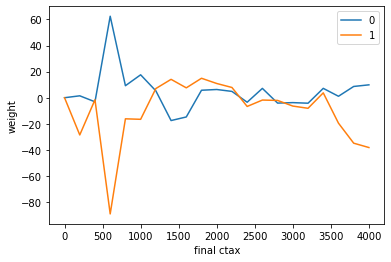

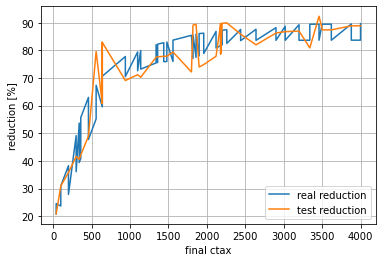

In [708]:
"""
train prepared dataframe 

input: ctax paths with reduction

output: trained dataset
"""

reload(emulate)

x = emulate.CtaxRedEmulator(lin_paths, combi, test_size)

x.train_ctax_path(stepsize_ctax_paths, number_of_weights)   
    
x.test_ctax_paths() 


method:  multivariate linear regression 
 RMSE:  9.49947145270226 
 R-squared:  0.5052816083069094
method:  polynomial regression 
 RMSE:  2.368942389999926 
 R-squared:  0.9692342029601535
method:  logistic regression 
 RMSE:  6.621973659861897 
 R-squared:  0.7596002177448917
method:  ridge regression 
 RMSE:  9.50256808255923 
 R-squared:  0.5049590199516257
method:  lasso regression 
 RMSE:  9.502546995030029 
 R-squared:  0.5049612170796967
method:  regression tree 
 RMSE:  0.5763713171542239 
 R-squared:  0.9981787737868447


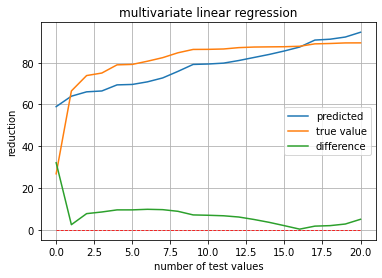

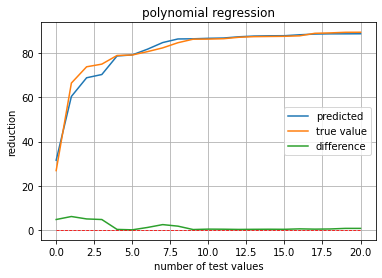

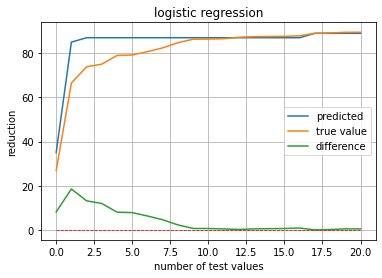

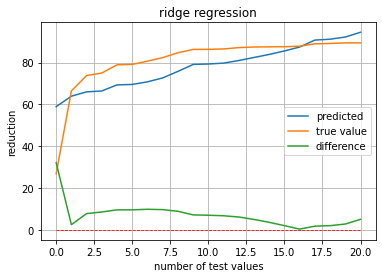

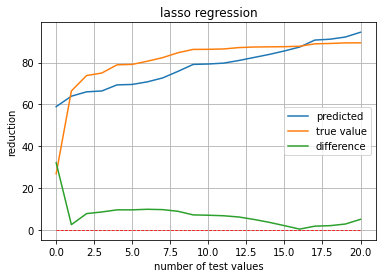

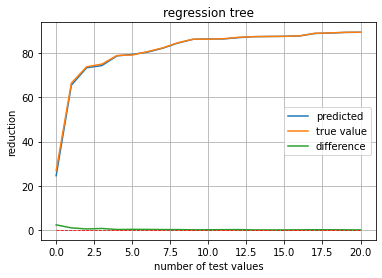

In [702]:
reload(emulate)

x = emulate.CtaxRedEmulator(lin_paths, root_paths, test_size)

# multi linear regression model
multi_lin_regr_mod = x.train_ctax_MLR()
multi_lin_plot = x.test_regr(multi_lin_regr_mod)

# polynomial regression model
degree = 3
poly_regr_mod = x.train_ctax_PR(degree)
poly_regr_plot = x.test_regr(poly_regr_mod)

# logistic regression model
log_regr_mod = x.train_ctax_LR()
log_regr_plot = x.test_regr(log_regr_mod)

# Ridge regression
alpha = 1
ridge_mod = x.train_ctax_ridge(alpha)
ridge_plot = x.test_regr(ridge_mod)

# lasso regression
alpha = 1
lasso_mod = x.train_ctax_lasso(alpha)
lasso_plot = x.test_regr(lasso_mod)

# regression tree
regr_tree = x.train_ctax_tree()
tree_plot = x.test_regr(regr_tree)

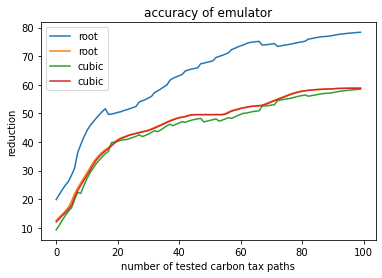

In [499]:
"""
Figures showing the emulated reduction vs real reduction

Also calculation of MSE

zelfde kleuren maar andere weergave
"""

reload(v1_plot)

v1_plot.emulator_v1_graphs(cubic_test, root_test)